<a href="https://colab.research.google.com/github/baddepudisaideepak/Comparative-analysis-of-Neural-Deep-learning-approaches-for-NEWS-text-Summarization/blob/main/finalprojectcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Concatenate, Dense, TimeDistributed, LSTM, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data ='https://raw.githubusercontent.com/baddepudisaideepak/Comparative-analysis-of-Neural-Deep-learning-approaches-for-NEWS-text-Summarization/refs/heads/main/news_summary.csv'
data_more ='https://raw.githubusercontent.com/baddepudisaideepak/Comparative-analysis-of-Neural-Deep-learning-approaches-for-NEWS-text-Summarization/refs/heads/main/news_summary_more.csv'


In [ ]:
data = pd.read_csv(data, encoding='latin-1')
df_more = pd.read_csv(data_more, encoding='latin-1')

In [ ]:
data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [10]:
# Drop columns that are not needed
data = data[['headlines', 'text']]

# Display the first few rows to ensure the DataFrame has only the required columns
data.head()

,headlines,text
0,daman diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...
1,malaika slams user who trolled her for divorc...,malaika arora slammed an instagram user who tr...
2,virgin now corrected to unmarried in igims...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya let man dujana before be...,lashkar e taiba s kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...


In [11]:
data.shape

(4514, 2)

In [12]:
def print_head(limit=5):
    # Ensure the limit does not exceed the number of rows in the dataset
    limit = min(limit, len(data))

    for idx in range(limit):
        print(f'TITLE: {data["headlines"][idx]}\nTEXT: {data["text"][idx]}\n')

# Call the function to print the first 5 headline-text pairs
print_head()


TITLE: daman   diu revokes mandatory rakshabandhan in offices order
TEXT: the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august 7  the administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media 

TITLE: malaika slams user who trolled her for  divorcing rich man  
TEXT: malaika arora slammed an instagram user who trolled her for  divorcing a rich man  and  having fun with the alimony    her life now is all about wearing short clothes  going to gym or salon  enjoying vacation s    the user commented  malaika responded   you certainly got to get your damn facts right before spewing sh t on me   when you know nothing about me  

TITLE:  virgin  now corrected to  unmarried  in igims  form
TEXT: the indira gandhi institute of medical sciences  igims  in patn

In [13]:
import re
import unicodedata

def preprocess(text):
    """Preprocess the given text for news summarization."""
    # Normalize Unicode characters to ASCII
    text = ''.join(
        c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'
    )

    # Convert text to lowercase
    text = text.lower()

    # Remove unwanted escape characters and special characters
    text = re.sub(r"(\\t|\\r|\\n|\s+.\s+)", ' ', text)  # Remove escape characters and single characters surrounded by spaces
    text = re.sub(r"[^\w\s]", ' ', text)  # Remove punctuation and special characters

    # Replace multiple occurrences of the same character
    text = re.sub(r"(--+|~~+|\+\++)", ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", ' ', text).strip()

    return text


data['headlines'] = data['headlines'].apply(preprocess)
data['text'] = data['text'].apply(preprocess)

# Display the first few rows to verify changes
data.head()


,headlines,text
0,daman diu revokes mandatory rakshabandhan in o...,the administration of union territory daman an...
1,malaika slams user who trolled her for divorci...,malaika arora slammed an instagram user who tr...
2,virgin now corrected to unmarried in igims form,the indira gandhi institute of medical science...
3,aaj aapne pakad liya let man dujana before bei...,lashkar taiba kashmir commander abu dujana who...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...


In [18]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=data)

https://docs.google.com/spreadsheets/d/1IlP_vZw48iuVeM7jY0iO0D6Or43RaYHad0HSaq7A3Gk#gid=0


In [15]:
# Display summary statistics of the dataset
data.describe(include='all')


,headlines,text
count,4514,4514
unique,4514,4514
top,daman diu revokes mandatory rakshabandhan in o...,the administration of union territory daman an...
freq,1,1


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  4514 non-null   object
 1   text       4514 non-null   object
dtypes: object(2)
memory usage: 70.7+ KB


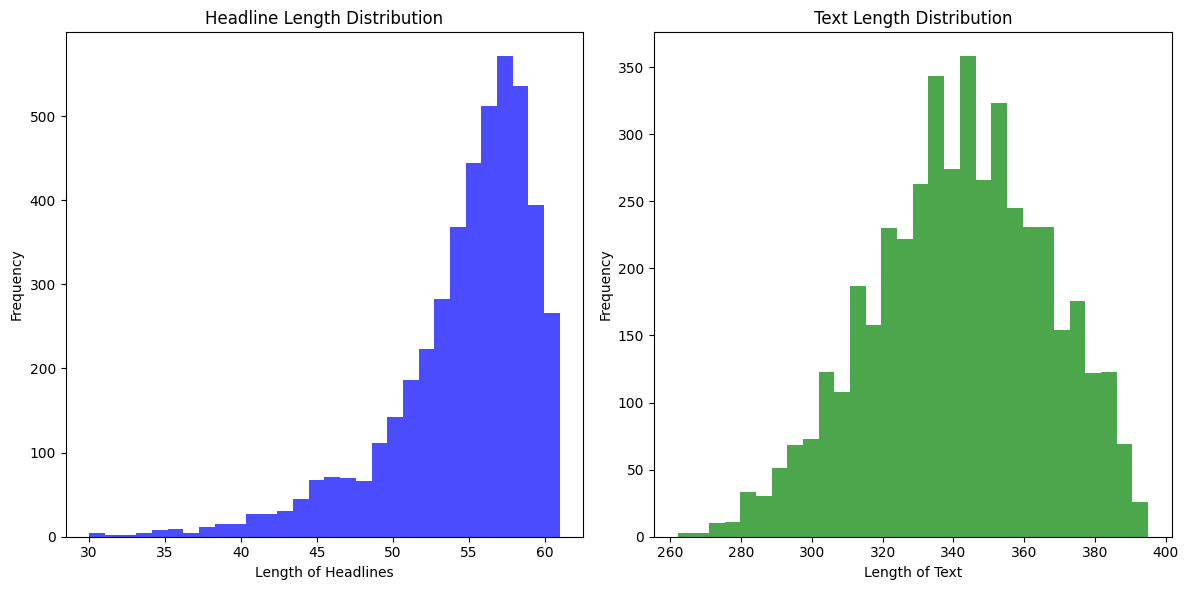

In [17]:
import matplotlib.pyplot as plt

# Calculate the length of each headline and text
data['headline_length'] = data['headlines'].apply(len)
data['text_length'] = data['text'].apply(len)

# Plotting the distribution of headline and text lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data['headline_length'], bins=30, color='blue', alpha=0.7)
plt.title('Headline Length Distribution')
plt.xlabel('Length of Headlines')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['text_length'], bins=30, color='green', alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


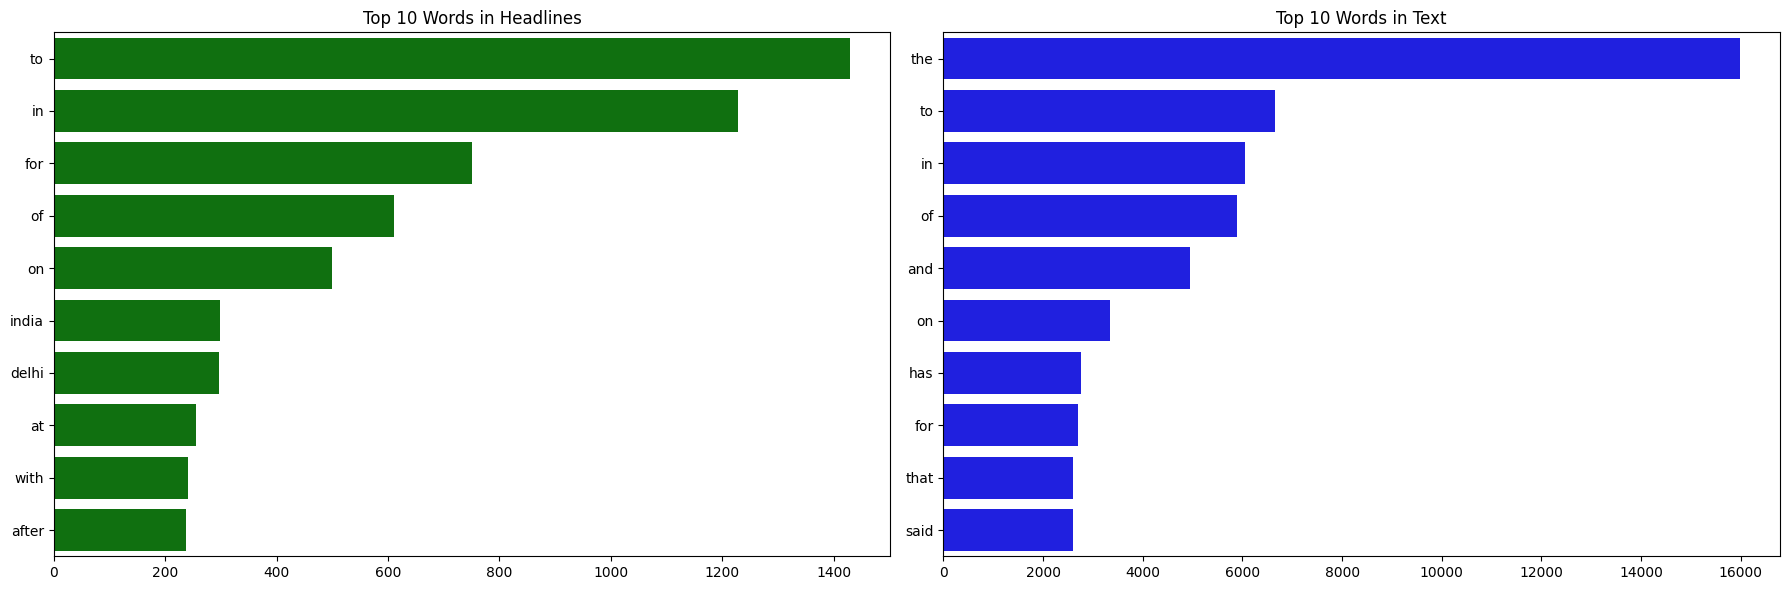

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Function to count words
def word_counter(text_series):
    count = Counter()
    for text in text_series:
        words = text.split()
        count.update(words)
    return count

# Count words in headlines and text
headline_words = word_counter(data['headlines'])
text_words = word_counter(data['text'])

# Most common words in headlines
common_headline_words = dict(headline_words.most_common(10))
common_text_words = dict(text_words.most_common(10))

# Plotting
plt.figure(figsize=(18, 6))

# For headlines
plt.subplot(1, 2, 1)
sns.barplot(x=list(common_headline_words.values()), y=list(common_headline_words.keys()), color='green')  # Specified color directly
plt.title('Top 10 Words in Headlines')

# For text
plt.subplot(1, 2, 2)
sns.barplot(x=list(common_text_words.values()), y=list(common_text_words.keys()), color='blue')  # Specified color directly
plt.title('Top 10 Words in Text')

plt.tight_layout()
plt.show()
